In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import math

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
PATH = '../../raw_data/Titanic/'

In [3]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        # ВАШ КОД ТУТ
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [4]:
def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float)

In [5]:
class Question:
    """A Question is used to partition a dataset.

    This class just records a 'column number' (e.g., 0 for Color) and a
    'column value' (e.g., Green). The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question. See the demo below.
    """

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            header[self.column], condition, str(self.value))

In [6]:
def partition(rows, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    #ВАШ КОД ТУТ
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [7]:
def gini(rows):
    """Calculate the Gini Impurity for a list of rows.

    There are a few different ways to do this, I thought this one was
    the most concise. See:
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """
    counts = class_counts(rows)
    impurity = 1
    #ВАШ КОД ТУТ
    for label in counts:
        prob = counts[label] / len(rows)
        impurity -= prob**2
    return impurity

In [8]:
def entropy(rows):
    counts = class_counts(rows)
    chaos = 0
    for label in counts:
        prob = counts[label] / len(rows)
        chaos -= -prob * math.log2(prob)
    return chaos

In [9]:
def info_gain(left, right, current_uncertainty):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    Usually:
    right is true_rows, 
    left is false_rows
    """
    info_gain = current_uncertainty
    
    left_uncertainty = gini(left)
    right_uncertainty = gini(right)
    
    info_gain -= len(left)/(len(left) + len(right)) * left_uncertainty
    info_gain -= len(right)/(len(left) + len(right)) * right_uncertainty
    
    return info_gain

In [10]:
def find_best_split(rows):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""
    best_avg_impurity = len(rows)  # keep track of the best information gain
    best_gain = 0
    
    best_question = None  # keep train of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature

        values = set([row[col] for row in rows])  # unique values in the column
        
        for val in values:  # for each value

            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(false_rows, true_rows, current_uncertainty)
            # avg_impurity = gini(true_rows)*len(true_rows) + gini(false_rows)*len(false_rows)

            # You actually can use '>' instead of '>=' here
            # but I wanted the tree to look a certain way for our
            # toy dataset. Use '>='.
            if gain >= best_gain:
                best_gain, best_question = gain, question
            #if avg_impurity <= best_avg_impurity:
            #    best_avg_impurity, best_question = avg_impurity, question

    #return best_avg_impurity, best_question
    return best_gain, best_question

In [11]:
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows):
        if 0 not in class_counts(rows):
            self.predictions = 1
        elif 1 not in class_counts(rows):
            self.predictions = 0
        else:
            self.predictions = class_counts(rows)[1]/(class_counts(rows)[0]+class_counts(rows)[1])

In [12]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [13]:
def build_tree(rows, max_depth, curr_depth=0):
    """Builds the tree.

    Rules of recursion: 1) Believe that it works. 2) Start by checking
    for the base case (no further information gain). 3) Prepare for
    giant stack traces.
    """

    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0 or check_same(rows) or max_depth==curr_depth:#вместо check_same тут можно проверять question на None :)
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows, max_depth, curr_depth+1)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows, max_depth, curr_depth+1)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # dependingo on the answer.
    return Decision_Node(question, true_branch, false_branch)

In [14]:
def check_same(rows):
    f = rows[0][:-1]
    same = True
    for row in rows:
        if row[:-1] != f: 
            same = False
    return same

In [15]:
header = ['Sex', 'Age', 'Survived']
def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [16]:
def classify(row, node):
    """See the 'rules of recursion' above."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [17]:
def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [18]:
genders = pd.read_csv(PATH + 'gender_submission.csv')
test = pd.read_csv(PATH + 'test.csv')
train = pd.read_csv(PATH + 'train.csv')

In [21]:
train = train[header]

In [22]:
def get_nan_info(df):
    """
    Статистика по наличию пропусков в признаках.
    df - датасет с признаками
    """
    df = df.copy()
    nans_df = pd.DataFrame(df.isnull().sum().rename('n_nans'))

    N = df.shape[0]
    nans_df['ratio_nans'] = nans_df['n_nans'] / N
    nans_df['ratio_nans'] = nans_df['ratio_nans'].round(2)

    nans_df = nans_df[nans_df['n_nans'] > 0]
    nans_df = nans_df.sort_values(by='n_nans', ascending=False)

    for feature in nans_df.index:
        nans_df.loc[feature, 'nan_target_mean'] = df[df[feature].isnull()]['Survived'].mean()
        nans_df.loc[feature, 'not_nan_target_mean'] = df[df[feature].notnull()]['Survived'].mean()

    return nans_df

In [24]:
medi_age = train['Age'].median()
train['Age'] = train['Age'].fillna(medi_age)

c:\users\aleks\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [26]:
train_list = train.values.tolist()

In [27]:
my_tree = build_tree(train_list, 10000)

In [28]:
def get_predict_proba(df_list, tree):
    '''Get list of probability predictions'''
    predictions = []
    for row in df_list:
        predictions.append(classify(row, tree))
    return predictions

In [29]:
def get_predict(df_list, tree, threshold):
    '''Составляет numpy array, в котором 1 соответствует вероятности принадлежности
    больше threshold и 0 меньше.'''
    predictions = []
    for row in df_list:
        predictions.append(classify(row, tree))
    predictions = (np.array(predictions)>threshold).astype(int)
    return predictions

In [30]:
train_df = train.copy()

In [31]:
kf = KFold(n_splits=5, shuffle=False)

In [32]:
logloss_score = []
accuracy_list = []

for train_index, valid_index in kf.split(train_df):
        train = train_df.iloc[train_index].copy()
        valid = train_df.iloc[valid_index].copy()
        
        train_list = train.values.tolist()
        valid_list = valid.values.tolist()
        
        my_tree = build_tree(train_list, 1000)
        
        y_pred_proba = get_predict_proba(valid_list, my_tree)
        y_pred = get_predict(valid_list, my_tree, 0.6)
        logloss_auc = round(roc_auc_score(valid['Survived'], y_pred_proba), 4)
        accuracy_crossval = round(accuracy_score(valid['Survived'], y_pred), 4)
        logloss_score.append(logloss_auc)
        accuracy_list.append(accuracy_crossval)

In [33]:
print('Accuracy score: ', accuracy_list, 'Auc_roc: ', logloss_score)

Accuracy score:  [0.7709, 0.7809, 0.7753, 0.6966, 0.7753] Auc_roc:  [0.7936, 0.7664, 0.7714, 0.7297, 0.8118]


In [34]:
train

Sex   Age  Survived
0      male  22.0         0
1    female  38.0         1
2    female  26.0         1
3    female  35.0         1
4      male  35.0         0
..      ...   ...       ...
708  female  22.0         1
709    male  28.0         1
710  female  24.0         1
711    male  28.0         0
712    male  48.0         1

[713 rows x 3 columns]

In [35]:
y_true = train['Survived']
y_predict_proba = get_predict_proba(train_list, my_tree)

In [36]:
precisions, recalls, thresholds = precision_recall_curve(y_true, y_predict_proba, pos_label=1)

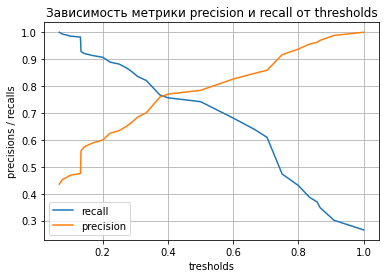

In [37]:
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, precisions[:-1], label='precision')
plt.legend()
plt.xlabel("tresholds")
plt.ylabel("precisions / recalls")
plt.title('Зависимость метрики precision и recall от thresholds')
plt.grid()
plt.show()

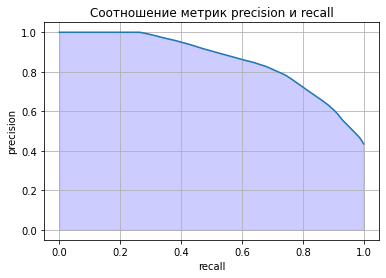

In [38]:
plt.plot(recalls, precisions)
plt.fill_between(recalls, precisions, alpha=0.2, color='blue')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Соотношение метрик precision и recall')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid()

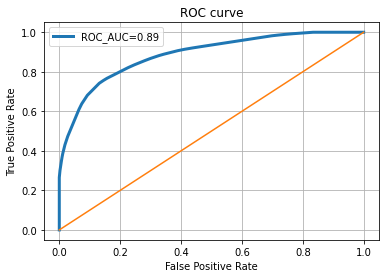

In [39]:
fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba, pos_label=1)
roc_auc_metric = np.round(roc_auc_score(y_true, y_predict_proba), 2)

plt.plot(fpr, tpr, lw=3, label='ROC_AUC={}'.format(roc_auc_metric))
plt.plot([0, 1], [0, 1])
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve')
plt.grid()
plt.show()

In [ ]:
# Find best depth for 2 features

In [40]:
kf = KFold(n_splits=5, shuffle=False)

In [42]:
# Find best depth for my model
best_depth, best_score_auc, score_acc = 0, 0, 0
for depth in range(1, 40):
    logloss_score = []
    accuracy_list = []
    for train_index, valid_index in kf.split(train_df):
        
        train = train_df.iloc[train_index].copy()
        valid = train_df.iloc[valid_index].copy()
        
        train_list = train.values.tolist()
        valid_list = valid.values.tolist()
        
        my_tree = build_tree(train_list, depth)
        
        y_pred_proba = get_predict_proba(valid_list, my_tree)
        y_pred = get_predict(valid_list, my_tree, 0.6)
        
        logloss_auc = round(roc_auc_score(valid['Survived'], y_pred_proba), 4)
        logloss_score.append(logloss_auc)
        accuracy_crossval = round(accuracy_score(valid['Survived'], y_pred), 4)
        accuracy_list.append(accuracy_crossval)
    if np.mean(logloss_score)>best_score_auc:
        best_depth, best_score_auc, score_acc = depth, round(np.mean(logloss_score), 4), round(np.mean(accuracy_list), 4)
print('Best depth: ', best_depth, 'Best auc score: ', best_score_auc, 'Accuracy: ', score_acc)

Best depth:  6 Best auc score:  0.7834 Accuracy:  0.7755


In [ ]:
# Build tree with more features

In [102]:
genders = pd.read_csv(PATH + 'gender_submission.csv')
test = pd.read_csv(PATH + 'test.csv')
train = pd.read_csv(PATH + 'train.csv')

In [84]:
header = ['Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']

In [86]:
medi_age = test['Age'].median()
test['Age'] = test['Age'].fillna(medi_age)
medi_fare = train['Fare'].median()
test['Fare'] = test['Fare'].fillna(medi_fare)

In [87]:
medi_age = train['Age'].median()
train['Age'] = train['Age'].fillna(medi_age)
mode = train['Embarked'].mode().iloc[0]
train['Embarked'] = train['Embarked'].fillna(mode)

In [88]:
train = train[header]

In [103]:
train

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [65]:
train_df = train.copy()

In [68]:
# Find best depth for my model
best_depth, best_score_auc, score_acc = 0, 0, 0
for depth in range(1, 30):
    logloss_score = []
    accuracy_list = []
    for train_index, valid_index in kf.split(train_df):
        
        train = train_df.iloc[train_index].copy()
        valid = train_df.iloc[valid_index].copy()
        
        train_list = train.values.tolist()
        valid_list = valid.values.tolist()
        
        my_tree = build_tree(train_list, depth)
        
        y_pred_proba = get_predict_proba(valid_list, my_tree)
        y_pred = get_predict(valid_list, my_tree, 0.6)
        
        logloss_auc = round(roc_auc_score(valid['Survived'], y_pred_proba), 4)
        logloss_score.append(logloss_auc)
        accuracy_crossval = round(accuracy_score(valid['Survived'], y_pred), 4)
        accuracy_list.append(accuracy_crossval)
    if np.mean(logloss_score)>best_score_auc:
        best_depth, best_score_auc, score_acc = depth, round(np.mean(logloss_score), 4), round(np.mean(accuracy_list), 4)
print('Best depth: ', best_depth, 'Best auc score: ', best_score_auc, 'Accuracy: ', score_acc)

Best depth:  4 Best auc score:  0.8491 Accuracy:  0.8025


In [ ]:
#Find thresholds

In [162]:
treshold_for_poitive = 0.9
treshold_for_negative = 0.15

In [160]:
logloss_score = []
accuracy_list = []
for train_index, valid_index in kf.split(train_df):
    
    train = train_df.iloc[train_index].copy()
    valid = train_df.iloc[valid_index].copy()
    
    train_list = train.values.tolist()
    valid_list = valid.values.tolist()
    
    my_tree = build_tree(train_list, 4)
    
    y_pred_proba = get_predict_proba(valid_list, my_tree)
    y_pred = get_predict(valid_list, my_tree, treshold_for_poitive)
    
    cm = confusion_matrix(valid['Survived'], y_pred, labels = [1, 0])
    tp, fn, fp, tn = cm.ravel()
    print(tp/(tp + fp))
    print(cm)

0.8333333333333334
[[ 15  44]
 [  3 117]]
0.9347826086956522
[[43 36]
 [ 3 96]]
0.8947368421052632
[[ 17  52]
 [  2 107]]
1.0
[[ 24  48]
 [  0 106]]
0.9318181818181818
[[ 41  22]
 [  3 112]]


In [163]:
logloss_score = []
accuracy_list = []
for train_index, valid_index in kf.split(train_df):
    
    train = train_df.iloc[train_index].copy()
    valid = train_df.iloc[valid_index].copy()
    
    train_list = train.values.tolist()
    valid_list = valid.values.tolist()
    
    my_tree = build_tree(train_list, 4)
    
    y_pred_proba = get_predict_proba(valid_list, my_tree)
    y_pred = get_predict(valid_list, my_tree, treshold_for_negative)
    
    cm = confusion_matrix(valid['Survived'], y_pred, labels = [1, 0])
    tp, fn, fp, tn = cm.ravel()
    print(tn/(tn + fn))
    print(cm)

0.872093023255814
[[48 11]
 [45 75]]
0.8409090909090909
[[65 14]
 [25 74]]
0.8876404494382022
[[59 10]
 [30 79]]
0.8514851485148515
[[57 15]
 [20 86]]
0.946236559139785
[[58  5]
 [27 88]]


In [ ]:
# Build tree for submission

In [90]:
test['Survived'] = 0

In [91]:
test = test[header]

In [92]:
test_list = test.values.tolist()
train_list = train.values.tolist()

In [93]:
my_tree = build_tree(train_list, 4)

In [95]:
tree_prediction = get_predict_proba(test_list, my_tree)

In [99]:
tree_prediction = np.array(tree_prediction)

In [111]:
tree_prediction_df = pd.DataFrame()

In [115]:
tree_prediction_df['PassengerId'] = test['PassengerId']
tree_prediction_df['Survived_proba'] = tree_prediction

In [116]:
tree_prediction_df['Survived'] = (tree_prediction_df['Survived_proba']>0.6).astype(int)

In [119]:
tree_prediction_df[['PassengerId', 'Survived']]

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]

In [120]:
# Save predictions
tree_prediction_df[['PassengerId', 'Survived']].to_csv('tree_pred.csv', index=False)